# **Portfolio optimization for 2030**

In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import cvxpy as cp

from prophet import Prophet

import sys
sys.path.append('../src')
from utils import *

# **We predict yearly carbon emission per surface, for 2030:**

We will train our model this time on `final_data.csv` entirely. We are looking for 2030 predictions.

In [2]:
# Read preprocessed data
data_raw = pd.read_csv('../data/processed/final_data.csv', index_col='Unnamed: 0', parse_dates=['date_etablissement_dpe'])

In [3]:
# Split data according to category
data = split(data_raw)

In [4]:
ts ={key: {freq: extract_vect_ts(df, freq) for freq in ['D', 'W', 'ME']} for key, df in data.items()}

We prepare the data for Prophet model

In [5]:
## Prophet nomenclature
def Prophetnom(df):
    df.reset_index(inplace=True)
    df.rename(columns={'date_etablissement_dpe':'ds','emission_ges':'y'}, inplace=True)

Prophetnom(ts['admin']['W'])
Prophetnom(ts['centre_com']['W'])
Prophetnom(ts['autre']['W'])
Prophetnom(ts['occup_cont']['W'])


Here, we create the model and we fit it

In [6]:
# Model for each category

model_admin=Prophet()
model_centre_com=Prophet()
model_autre=Prophet()
model_occup_cont=Prophet()


# Fitting 

model_admin.fit(ts['admin']['W'])
model_centre_com.fit(ts['centre_com']['W'])
model_autre.fit(ts['autre']['W'])
model_occup_cont.fit(ts['occup_cont']['W'])

00:08:56 - cmdstanpy - INFO - Chain [1] start processing
00:08:57 - cmdstanpy - INFO - Chain [1] done processing
00:08:57 - cmdstanpy - INFO - Chain [1] start processing
00:08:58 - cmdstanpy - INFO - Chain [1] done processing
00:08:58 - cmdstanpy - INFO - Chain [1] start processing
00:08:58 - cmdstanpy - INFO - Chain [1] done processing
00:08:58 - cmdstanpy - INFO - Chain [1] start processing
00:08:58 - cmdstanpy - INFO - Chain [1] done processing


In [7]:
# The forecast
# With the following exact periods, the last line of our predictions correspond to the first week of 2030
future_admin = model_admin.make_future_dataframe(periods=52 * 5+1, freq='W')
future_centre_com = model_centre_com.make_future_dataframe(periods=52 * 5+1, freq='W')
future_autre = model_autre.make_future_dataframe(periods=52 * 5+1, freq='W')
future_occup_cont = model_occup_cont.make_future_dataframe(periods=52 * 5+1, freq='W')

forecast_admin = model_admin.predict(future_admin)
forecast_centre_com = model_centre_com.predict(future_centre_com)
forecast_autre = model_autre.predict(future_autre)
forecast_occup_cont = model_occup_cont.predict(future_occup_cont)

# **We use `markowitz_dataset.csv` to build a credit rate table by building category:**

In [8]:
data_rate = pd.read_csv('../data/raw/markowitz_dataset.csv', encoding='latin1', usecols=['asset_type_cre', 'taux_credit'])

In [9]:
data_rate=pd.DataFrame(data_rate.groupby('asset_type_cre').mean())

In [10]:
data_rate.reset_index(inplace=True)

In [11]:
def asset_type_format_fct(x):
    return asset_type_format[x]


asset_type_format={"Bâtiment à usage principale de bureau, d'administration ou d'enseignement":"admin",
                   "Bâtiment à occupation continue (par exemple: hopitaux, hôtels, internats, maisons de retraite, etc)":"occup_cont",
                   "Autres cas (par exemple: théâtres, salles de sport, restauration, commerces individuels, etc)":"autre",
                   "Centre commercial":"centre_com"}

In [12]:
data_rate.asset_type_cre=data_rate.asset_type_cre.apply(asset_type_format_fct)

In [13]:
data_rate

,asset_type_cre,taux_credit
0,autre,0.032059
1,occup_cont,0.022727
2,admin,0.020678
3,centre_com,0.023780


In [14]:
forecast_admin['yhat'].iloc[-1]

11.617772073894313

In [15]:
data_emission_2030=pd.DataFrame({'asset_type_cre':['admin','autre','centre_com','occup_cont'],
                                 'emission_ges':[forecast_admin['yhat'].iloc[-1],forecast_autre['yhat'].iloc[-1],forecast_centre_com['yhat'].iloc[-1],forecast_occup_cont['yhat'].iloc[-1]]})


In [16]:
data_emission_2030

,asset_type_cre,emission_ges
0,admin,11.617772
1,autre,15.692469
2,centre_com,9.778857
3,occup_cont,11.140794


In [17]:
data_2030=data_rate.set_index('asset_type_cre', drop=True).join(data_emission_2030.set_index('asset_type_cre',drop=True))

In [18]:
data_2030

,taux_credit,emission_ges
asset_type_cre,,
autre,0.032059,15.692469
occup_cont,0.022727,11.140794
admin,0.020678,11.617772
centre_com,0.023780,9.778857


As we did in `optim1.ipynb`, we solve the optimisation problem:

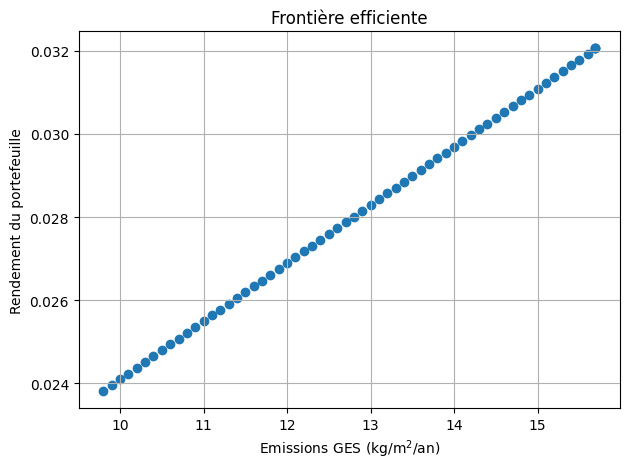

In [21]:
# Inputs
r = np.array(data_2030.taux_credit)
e = np.array(data_2030.emission_ges)
n = len(r)

# Visualisation
r_opt = []
e_opt = []
w_opt = []

for t in np.arange(9.8, 16, 0.1):
    w = cp.Variable(n, nonneg=True)
    objective = cp.Minimize(- w@r)
    contraints = [
        cp.sum(w) == 1, 
        w@e <= t
    ]

    # Résolution
    prob = cp.Problem(objective, contraints)
    prob.solve()
    
    w = w.value
    
    w_opt.append(w)
    r_opt.append(w@r)
    e_opt.append(w@e)

def singularities(x, y, tol):
    singu = []
    for i in range(1, len(y)-1):
        if abs(((y[i+1] - y[i])/(x[i+1] - x[i])) - ((y[i] - y[i-1])/(x[i] - x[i-1])))>tol:
            singu.append([x[i], y[i]])
    return singu


singu = np.array(singularities(e_opt, r_opt, tol=1e-6))
plt.scatter(x=e_opt, y=r_opt)

plt.grid(True)
plt.ylabel("Rendement du portefeuille")
plt.xlabel("Emissions GES (kg/m$^2$/an)")
plt.title("Frontière efficiente")
plt.tight_layout()
plt.show()